In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
net = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) # UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
for param in net.parameters():
    param.requires_grad=False#把参数冻结住，反向传播时不修改
features=net.fc.in_features
net.fc=nn.Linear(features, 2)

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
# help(datasets.ImageFolder.find_classes)

In [5]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

class PrefixImageFolder(datasets.ImageFolder):
    
    def find_classes(self, directory):
        classes = sorted(set(entry.name.split('.')[0] for entry in os.scandir(directory)))
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def make_dataset(self, directory: str,
                     class_to_idx: Optional[Dict[str, int]] = None,
                     extensions: Optional[Union[str, Tuple[str, ...]]] = None,
                     is_valid_file: Optional[Callable[[str], bool]] = None,
                    ):
        
        directory = os.path.expanduser(directory)

        if class_to_idx is None:
            _, class_to_idx = find_classes(directory)
        elif not class_to_idx:
            raise ValueError("'class_to_index' must have at least one entry to collect any samples.")

        both_none = extensions is None and is_valid_file is None
        both_something = extensions is not None and is_valid_file is not None
        if both_none or both_something:
            raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")

        if extensions is not None:

            def is_valid_file(x: str) -> bool:
                return x.lower().endswith(extensions if isinstance(extensions, str) else tuple(extensions)) # has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]

        is_valid_file = cast(Callable[[str], bool], is_valid_file)

        instances = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = directory # os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = path, class_index
                        instances.append(item)

                        if target_class not in available_classes:
                            available_classes.add(target_class)

        empty_classes = set(class_to_idx.keys()) - available_classes
        if empty_classes:
            msg = f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
            if extensions is not None:
                msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
            raise FileNotFoundError(msg)

        return instances

{'cat': 0, 'dog': 1}
['cat', 'dog']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


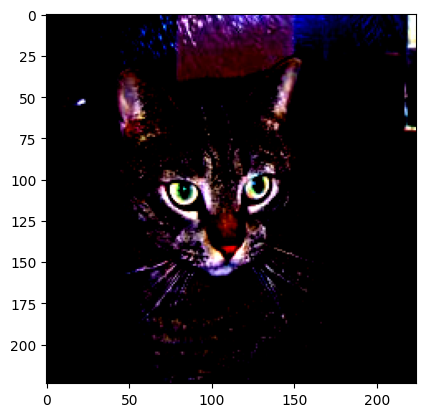

In [6]:
train_data=PrefixImageFolder(root='./train/',
                             transform=transforms.Compose([
                                 transforms.Resize([224, 224]), #随机裁剪224*224大小
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                             ]
                             )
                            )

print(train_data.class_to_idx)
print(train_data.classes)
img=train_data[1][0]
label=train_data[1][1]
print(label)
plt.imshow(img.permute([1,2,0]))
plt.show()

In [7]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

class TestImageFolder(PrefixImageFolder):
    
    def find_classes(self, directory):
        classes = ['.']
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [8]:
test_data=TestImageFolder(root='./test1/',
                               transform=transforms.Compose([
                                   transforms.Resize([224,224]),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               ]
                               )
                              )

In [9]:
train_loader=DataLoader(train_data, batch_size=8, shuffle=True)

In [10]:
test_loader=DataLoader(test_data, batch_size=8, shuffle=True)

tensor([[[ 0.3481,  0.3309,  0.3309,  ..., -0.5424, -0.4911, -0.2171],
         [ 0.3309,  0.3138,  0.3138,  ..., -0.5253, -0.3712, -0.0458],
         [ 0.3309,  0.3138,  0.3138,  ..., -0.5253, -0.2171,  0.1768],
         ...,
         [ 1.1358,  1.2214,  1.2899,  ...,  2.1462,  1.9749,  1.9235],
         [ 1.1187,  1.1700,  1.2728,  ...,  2.1462,  1.9920,  1.9407],
         [ 1.1700,  1.1015,  1.2214,  ...,  2.1462,  2.0092,  1.9578]],

        [[ 0.5378,  0.5203,  0.5203,  ..., -0.1800, -0.1450,  0.1352],
         [ 0.5203,  0.5028,  0.5028,  ..., -0.1625, -0.0224,  0.3102],
         [ 0.5203,  0.5028,  0.5028,  ..., -0.1625,  0.1352,  0.5378],
         ...,
         [ 1.1681,  1.2556,  1.3256,  ...,  2.3235,  2.1485,  2.0959],
         [ 1.1681,  1.2206,  1.3256,  ...,  2.3410,  2.1660,  2.1310],
         [ 1.2556,  1.1856,  1.3081,  ...,  2.3585,  2.2185,  2.1660]],

        [[ 0.8797,  0.8797,  0.8971,  ...,  0.2173,  0.2348,  0.5136],
         [ 0.8622,  0.8622,  0.8797,  ...,  0

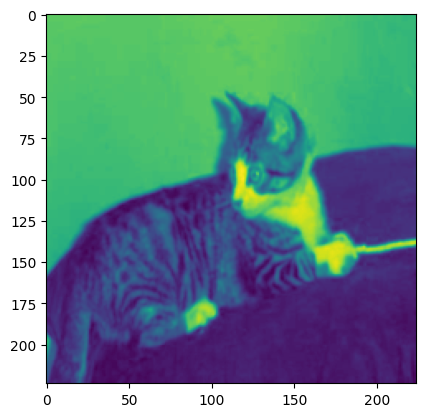

In [11]:
img=test_data[10][0].numpy()
label=train_data[10][0]
print(label)
plt.imshow(img[0,:]) #  plt.imshow(img.permute([1,2,0]))
plt.show()

In [12]:
#二===三三三==三=三======采用固定值方式迁移Resnet18网络======二三后三二二三三=
net = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) # (pretrained=True)
for param in net.parameters():
    param.requires_grad=False # 把参数冻结住，反向传播时不修改
features=net.fc.in_features
net.fc=nn.Linear(features,2)
# print(net)
for name, parameter in net.layer4.named_parameters():
     parameter.requires_grad = True
for name, parameter in net.avgpool.named_parameters():
     parameter.requires_grad = True

if torch.cuda.is_available():
    net=net.cuda() # 网络加载到GPU上
    net.fc=net.fc.cuda()
                           
loss_fn=nn.CrossEntropyLoss()
opt=torch.optim.SGD(net.fc.parameters(),lr=0.001,momentum=0.9)

In [ ]:
#===三三三=三三三======训练======三三三三三=========—========
for epoch in range(20):
    for i, data in enumerate(train_loader):
        x, y=data
        if torch.cuda.is_available():
            x=x.cuda()
            y=y.cuda()
        pred=net(x)
        loss=loss_fn(pred,y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    if(epoch%2==0):
        print(loss.data)

tensor(0.8770, device='cuda:0')
tensor(0.9703, device='cuda:0')
tensor(0.7053, device='cuda:0')
tensor(0.7477, device='cuda:0')
tensor(0.9410, device='cuda:0')
tensor(0.6605, device='cuda:0')
tensor(0.6926, device='cuda:0')
tensor(0.6790, device='cuda:0')
tensor(0.8655, device='cuda:0')


In [ ]:
#三==三三三三=====计算正确率====二二三=三二二二三二二三三三三=
def rightness(pred,labels):
    pred=torch.max(pred.data,1)[1]
    rights=pred.eq(labels.data.view_as(pred)).sum()
    return rights,len(labels)

In [ ]:
#===三三三三三=SS====测试（验证）)==二二二二二二二二二二二
rights=0
length=0
for i, data in enumerate(test_loader):
    x, y=data
    if torch.cuda.is_available():
        x=x.cuda()
        y=y.cuda()
    net.eval() #关闭dropout
    pred=net(x)
    rights=rights+rightness(pred,y)[0]
    length=length+rightness(pred,y)[1]

print(rights,length,rights/length)